# Brain Tumor Detection Using Convolutional Neural Network
This project presents a Convolutional Neural Network (CNN) - based approach to detect and classify brain tumors from MRI images. It includes two models that are binary classification and multi-class classification. Using a publicly available dataset sourced from Kaggle containing over 7,000 classified MRI scans, the project works on two models including binary classification and multi-class classification. While binary classification detects the presence or absence of a tumor, multi-class classification identifies specific tumor types including glioma, meningioma, pituitary, and no tumor. Preprocessing involved resizing, normalizing images, and label encoding, and the data was split into training, validation, and test sets. The model achieved high accuracy and shows promise as a tool to assist medical professionals in early tumor detection.

## 1. Import Necessary Modules

In [4]:
!pip install tensorflow

In [6]:
!pip install opencv-python

In [8]:
!pip install imutils

In [201]:
%matplotlib inline

#Built-in
import os
import random

# Data science + preprocessing
import shutil
import time
import numpy as np
import cv2
import imutils
from PIL import Image
import zipfile

# Visualization
import matplotlib.pyplot as plt

# TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## 2. Setup and Download Dataset

**About the Brain Tumor MRI dataset:**

The dataset contains two folders: Training, which includes 5,712 images, and Testing, which includes 1,311 images. You can find it [here](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data).

In [13]:
!pip install kaggle

In [15]:
# Create a custom config directory to store kaggle.json securely
custom_config_dir = os.path.join(os.getcwd(), "kaggle_config")
os.makedirs(custom_config_dir, exist_ok=True)

# Copy the kaggle.json file
shutil.copy("kaggle.json", os.path.join(custom_config_dir, "kaggle.json"))

# Lock permissions for security 
!chmod 600 kaggle_config/kaggle.json

# Set environment variable
os.environ['KAGGLE_CONFIG_DIR'] = custom_config_dir

# Download dataset
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

#Unzip data
with zipfile.ZipFile("brain-tumor-mri-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("brain_tumor_mri_dataset")

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
brain-tumor-mri-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


## 3. Define Helper Functions

In [18]:
# 3.1 Preprocessing Function

def preprocess_images(dataset_dir, target_size=(240, 240), mode="binary"):
    """
    Loads and preprocesses images from dataset_dir.

    Args:
        dataset_dir (str): Path to dataset.
        target_size (tuple): Image resize target size.
        mode (str): "binary" or "multiclass"

    Returns:
        Tuple of (images, labels) as NumPy arrays.
    """
    import os
    from PIL import Image
    import numpy as np

    images = []
    labels = []

    label_map = {
        'glioma': 0,
        'meningioma': 1,
        'pituitary': 2,
        'notumor': 3
    }

    for label_name in os.listdir(dataset_dir):
        label_path = os.path.join(dataset_dir, label_name)
        if os.path.isdir(label_path):
            if mode == "binary":
                label = 0 if label_name.lower() == "notumor" else 1
            elif mode == "multiclass":
                label = label_map.get(label_name.lower())
                if label is None:
                    print(f"Skipping unknown folder: {label_name}")
                    continue  # Skip unknown folders

            for img_name in os.listdir(label_path):
                img_path = os.path.join(label_path, img_name)
                try:
                    img = Image.open(img_path).convert('RGB')
                    img = img.resize(target_size)
                    img_array = np.array(img) / 255.0
                    images.append(img_array)
                    labels.append(label)
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")

    return np.array(images), np.array(labels)

In [20]:
# 3.2 Split Function

def split_data(X, y, test_size=0.2, random_state=42):
    """
    Splits data into training, validation, and test sets.
    Returns:
        - X_train, y_train: 60%
        - X_val, y_val: 20%
        - X_test, y_test: 20%
    """
    # First split: 80% train, 20% temp (val+test)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )
    
    # Second split: 50% val, 50% test from the 20%
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=random_state
    )
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [73]:
def compute_f1_score(y_true, prob, average='weighted'):
    """
    Computes the F1 score for binary or multi-class predictions.
    
    Args:
        y_true: Ground truth labels
        prob: Predicted probabilities
        average: Averaging method for multi-class ('binary', 'macro', 'weighted')

    Returns:
        F1 score
    """
    if prob.ndim > 1 and prob.shape[1] > 1:
        # Multi-class: pick the class with highest probability
        y_pred = np.argmax(prob, axis=1)
    else:
        # Binary: threshold at 0.5
        y_pred = np.where(prob > 0.5, 1, 0)

    return f1_score(y_true, y_pred, average=average)

In [75]:
# Nicely formatted time string as hours:minutes:seconds
def hms_string(sec_elapsed):
    h = int(sec_elapsed // 3600)
    m = int((sec_elapsed % 3600) // 60)
    s = int(sec_elapsed % 60)
    return f"{h}:{m:02}:{s:02}"

## 4. Preprocess the Dataset for binary & multi-class

In [23]:
image_dir = "brain_tumor_mri_dataset/Training"

In [25]:
test_dir = "brain_tumor_mri_dataset/Testing"

### 4.1 For Binary

In [28]:
X_binary, y_binary = preprocess_images(image_dir, mode='binary')

In [29]:
X_train_bin, y_train_bin, X_val_bin, y_val_bin, X_test_bin, y_test_bin = split_data(X_binary, y_binary)

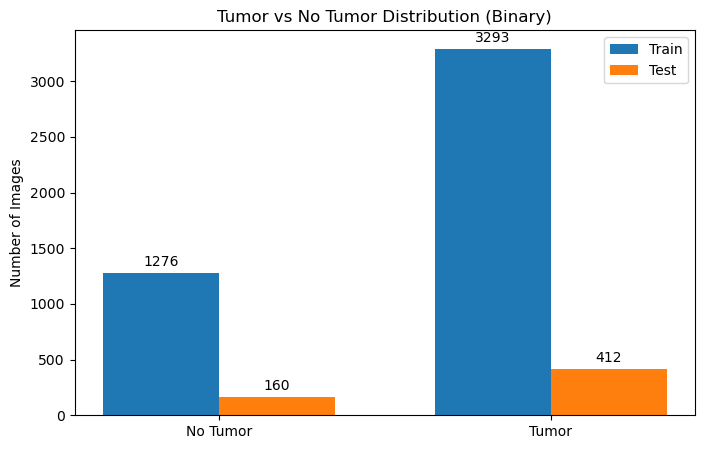

In [30]:
# For training set
unique_bin, counts_bin = np.unique(y_train_bin, return_counts=True)
train_counts_bin = dict(zip(unique_bin, counts_bin))

# For testing set
unique_test_bin, counts_test_bin = np.unique(y_test_bin, return_counts=True)
test_counts_bin = dict(zip(unique_test_bin, counts_test_bin))

# Define class labels
labels = ['No Tumor', 'Tumor']

# Get values in label order (0, 1)
train_values = [train_counts_bin.get(0, 0), train_counts_bin.get(1, 0)]
test_values = [test_counts_bin.get(0, 0), test_counts_bin.get(1, 0)]

x = np.arange(len(labels))
width = 0.35

# Plot
fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width/2, train_values, width, label='Train')
rects2 = ax.bar(x + width/2, test_values, width, label='Test')

# Add text labels above bars
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

ax.set_ylabel('Number of Images')
ax.set_title('Tumor vs No Tumor Distribution (Binary)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()

### 4.2 For Multi-Class

In [35]:
X_multi, y_multi = preprocess_images(image_dir, mode='multiclass')

In [36]:
X_train_multi, y_train_multi, X_val_multi, y_val_multi, X_test_multi, y_test_multi = split_data(X_multi, y_multi)

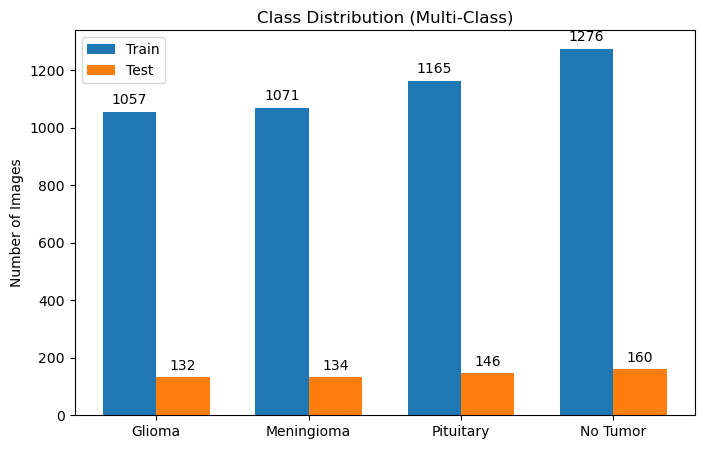

In [37]:
# For training set
unique_multi, counts_multi = np.unique(y_train_multi, return_counts=True)
train_counts_multi = dict(zip(unique_multi, counts_multi))

# For testing set
unique_test_multi, counts_test_multi = np.unique(y_test_multi, return_counts=True)
test_counts_multi = dict(zip(unique_test_multi, counts_test_multi))

# Define class labels in correct order
class_labels = ['Glioma', 'Meningioma', 'Pituitary', 'No Tumor']

# Get values in label order (0 to 3)
train_values = [train_counts_multi.get(i, 0) for i in range(4)]
test_values = [test_counts_multi.get(i, 0) for i in range(4)]

x = np.arange(len(class_labels))
width = 0.35

# Plot
fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width/2, train_values, width, label='Train')
rects2 = ax.bar(x + width/2, test_values, width, label='Test')

# Add text labels above bars
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

ax.set_ylabel('Number of Images')
ax.set_title('Class Distribution (Multi-Class)')
ax.set_xticks(x)
ax.set_xticklabels(class_labels)
ax.legend()
plt.show()

# Part 1: Binary Classification (Tumor vs No Tumor)

## 1. Visualize Sample Images with Labels

In [45]:
def plot_sample_images(X, y, n=50):
    """
    Plots sample images for each label class (0 = No Tumor, 1 = Tumor).

    Args:
        X (np.ndarray): Image data.
        y (np.ndarray): Corresponding labels.
        n (int): Number of images per class to display.
    """
    for label in [0, 1]:
        label_images = X[y == label]
        images = label_images[:min(n, len(label_images))]

        columns_n = 10
        rows_n = int(np.ceil(len(images) / columns_n))

        fig = plt.figure(figsize=(15, 3.5))
        fig.subplots_adjust(hspace=0, wspace=0.2) 

        for i, image in enumerate(images):
            ax = plt.subplot(rows_n, columns_n, i + 1)
            ax.imshow(image, cmap='gray')
            ax.axis('off')

        label_str = "Tumor" if label == 1 else "No Tumor"
        plt.suptitle(f"Brain Tumor: {label_str}", fontsize=20)
        plt.show()

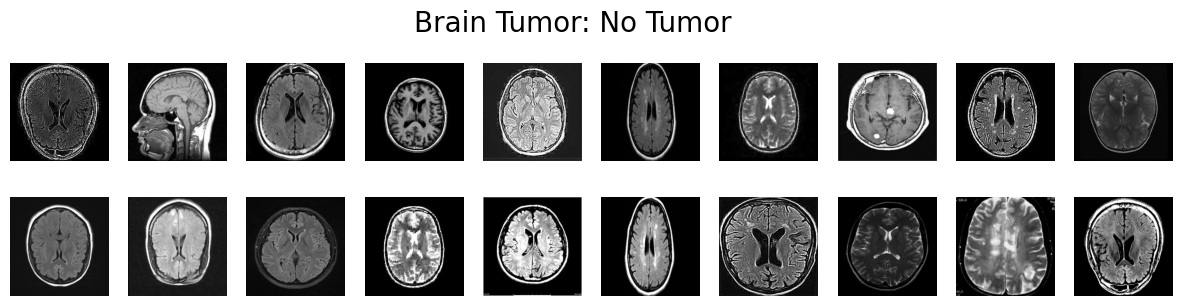

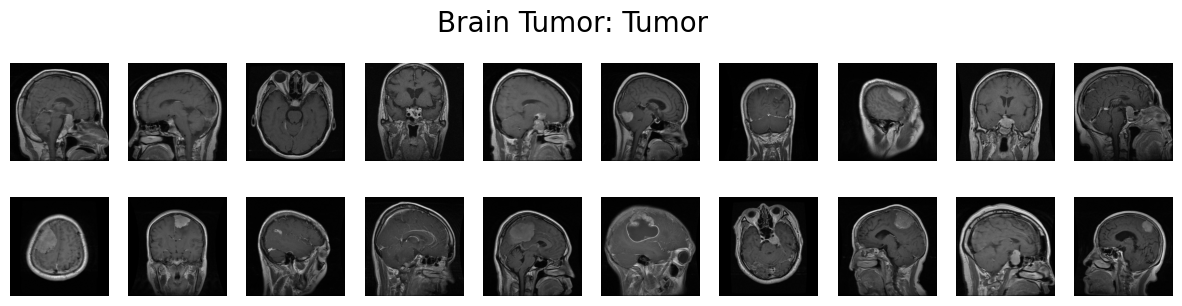

In [49]:
plot_sample_images(X_test_bin, y_test_bin, n=20)

## 2. Dataset Splitting Summary (Binary Classification)
The binary classification dataset was split as follows:
- 70% for training  
- 15% for validation  
- 15% for testing  

Below is a summary of the shapes:

In [66]:
print ("number of training examples = " + str(X_train_bin.shape[0]))
print ("number of development examples = " + str(X_val_bin.shape[0]))
print ("number of test examples = " + str(X_test_bin.shape[0]))
print ("X_train_bin shape: " + str(X_train_bin.shape))
print ("Y_train_bin shape: " + str(y_train_bin.shape))
print ("X_val_bin (dev) shape: " + str(X_val_bin.shape))
print ("Y_val_bin (dev) shape: " + str(y_val_bin.shape))
print ("X_test_bin shape: " + str(X_test_bin.shape))
print ("Y_test_bin shape: " + str(y_test_bin.shape))

number of training examples = 4569
number of development examples = 571
number of test examples = 572
X_train_bin shape: (4569, 240, 240, 3)
Y_train_bin shape: (4569,)
X_val_bin (dev) shape: (571, 240, 240, 3)
Y_val_bin (dev) shape: (571,)
X_test_bin shape: (572, 240, 240, 3)
Y_test_bin shape: (572,)


## 3. Build the model

Let's build a convolutional neural network model:

In [78]:
def build_binary_model(input_shape=(240, 240, 3)):
    inputs = Input(shape=input_shape)

    # ZeroPadding2D
    x = ZeroPadding2D(padding=(2, 2))(inputs)

    # Conv2D -> BatchNorm -> ReLU
    x = Conv2D(32, (7, 7), strides=1)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # MaxPool 1
    x = MaxPooling2D(pool_size=(4, 4))(x)

    # MaxPool 2
    x = MaxPooling2D(pool_size=(4, 4))(x)

    # Flatten & Fully Connected Layer
    x = Flatten()(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [84]:
binary_model = build_binary_model()
binary_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_2                │ (None, 244, 244, 3)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 238, 238, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 238, 238, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 238, 238, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,137 (43.50 KB)

 Trainable params: 11,073 (43.25 KB)

 Non-trainable params: 64 (256.00 B)

**Compile the binary model**

In [119]:
# Model Compilation to prepare the binary model for training
binary_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [121]:
# Set up logging for TensorBoard to visualize training/validation loss and accuracy in real-time
log_file_name = f'binary_model_logs_{int(time.time())}'
tensorboard_bin = TensorBoard(log_dir=f'logs/{log_file_name}')

In [123]:
# Save the model that performs best on validation accuracy
filepath = "binary-model-epoch{epoch:02d}-val_acc{val_accuracy:.2f}"
checkpoint_bin = ModelCheckpoint(
    f"models/{filepath}.keras",
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

In [125]:
# Stop training if val_accuracy doesn't improve after 10 epochs
early_stop_bin = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

## 4. Train the model

In [127]:
print(f"Train on {X_train_bin.shape[0]} samples, validate on {X_val_bin.shape[0]} samples")

start_time = time.time()

history = binary_model.fit(
    X_train_bin, y_train_bin,
    validation_data=(X_val_bin, y_val_bin),
    callbacks=[tensorboard_bin, checkpoint_bin, early_stop_bin],
    epochs=30,
    batch_size=32
)
end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Train on 4569 samples, validate on 571 samples
Epoch 1/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.8472 - loss: 0.3620 - val_accuracy: 0.8669 - val_loss: 0.3135
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.9462 - loss: 0.1590 - val_accuracy: 0.8687 - val_loss: 0.2917
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.9561 - loss: 0.1299 - val_accuracy: 0.8897 - val_loss: 0.2510
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.9612 - loss: 0.1222 - val_accuracy: 0.9475 - val_loss: 0.1523
Epoch 5/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step - accuracy: 0.9619 - loss: 0.1108 - val_accuracy: 0.9562 - val_loss: 0.1316
Epoch 6/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.9679 - loss: 0.1110 - val_accuracy: 0.9352 - val_loss: 0.1961
Epoch 7/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step - accuracy: 0.9723 - loss: 0.0909 - val_accuracy: 0.9615 - val_loss: 0.1202
Epoch 8/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/st

### When will training stop?
Using EarlyStopping to prevent overfitting and save time during training.

Monitor: val_accuracy (validation accuracy)

Patience: 10

This means training will stop early if the validation accuracy does not improve after 10 consecutive epochs.

In this case, training ran all 30 epochs, meaning the model's performance kept improving (or fluctuating) enough to avoid early stopping.

In [146]:
history_binary = binary_model.history.history

In [147]:
for key in history_binary.keys():
    print(key)

accuracy
loss
val_accuracy
val_loss


## 5. Plot Training vs. Validation Accuracy & Loss

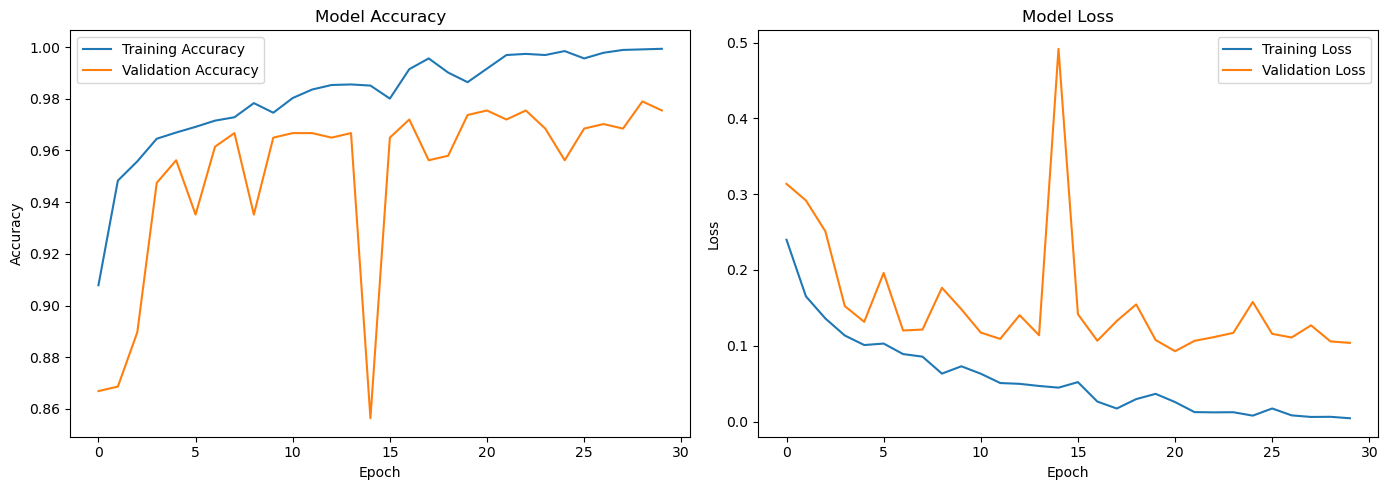

In [151]:
# Plot accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_binary['accuracy'], label='Training Accuracy')
plt.plot(history_binary['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
## 5. Plot Training vs. Validation Accuracy & Loss
# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_binary['loss'], label='Training Loss')
plt.plot(history_binary['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## 6. Interpreting Training/Validation Accuracy and Loss 

### Model Performance Overview:

- Training Accuracy steadily increases and reaches nearly 100%, indicating the model is effectively learning the training data.

- Validation Accuracy also remains high (above 97% in most epochs), which shows good generalization to unseen data.

- Training Loss consistently decreases, approaching near-zero, as expected in a well-trained model.

- Validation Loss, while low, shows some fluctuation, which may indicate mild overfitting or sensitivity to specific validation samples.

### Further Steps to Improve the Model

- Add Dropout Layers
Introduce dropout (e.g., 0.3–0.5) after convolutional or dense layers to reduce overfitting.

- Data Augmentation
Increase image variety using augmentation (rotation, zoom, horizontal flip) to make the model more robust.

- Reduce Model Complexity
Try reducing filter sizes or removing one MaxPooling layer to prevent the model from memorizing training data.

- Tune Learning Rate or Optimizer
Experiment with learning rate schedules or optimizers like RMSprop or SGD with momentum.

- Use Validation Smoothing
Apply techniques like exponential moving average or cross-validation to stabilize validation performance.

- Increase Patience for EarlyStopping
If training continues to improve after small plateaus, allowing more patience (e.g., 15) may help reach better accuracy.

## 7. Results for Binary Classification

This section presents the final model performance and prediction results on unseen test data.

### 7.1 Load the best model

In [175]:
for file in os.listdir("models"):
    if file.startswith("binary-model") and file.endswith(".keras"):
        print(file)

binary-model-epoch17-val_acc0.97.keras
binary-model-epoch01-val_acc0.87.keras
binary-model-epoch29-val_acc0.98.keras
binary-model-epoch20-val_acc0.97.keras
binary-model-epoch08-val_acc0.97.keras
binary-model-epoch02-val_acc0.87.keras
binary-model-epoch04-val_acc0.95.keras
binary-model-epoch03-val_acc0.89.keras
binary-model-epoch07-val_acc0.96.keras
binary-model-epoch05-val_acc0.96.keras
binary-model-epoch21-val_acc0.98.keras


In [177]:
best_binary_model = load_model("models/binary-model-epoch21-val_acc0.98.keras")

### 7.2 Evaluate the Model on the Test Set:

In [185]:
test_loss_bin, test_acc_bin = binary_model.evaluate(X_test_bin, y_test_bin, verbose=1)
print(f"Test Accuracy: {test_acc_bin:.4f}")
print(f"Test Loss: {test_loss_bin:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.9837 - loss: 0.0498
Test Accuracy: 0.9773
Test Loss: 0.0735


### 7.3 F1 score for the best model on the testing data:

F1 score helps us measure how well the model balances between detecting tumors and avoiding false alarms — making it a more reliable metric for medical classification problems than accuracy alone.

In [190]:
# Get predictions from the model
y_pred_probs_bin = best_binary_model.predict(X_test_bin)
y_pred_bin = (y_pred_probs_bin > 0.5).astype("int32")

# Print F1 Score and other metrics
print("F1 Score:", f1_score(y_test_bin, y_pred_bin))
print("\nClassification Report:\n", classification_report(y_test_bin, y_pred_bin))

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step
F1 Score: 0.983132530120482

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.94      0.96       160
           1       0.98      0.99      0.98       412

    accuracy                           0.98       572
   macro avg       0.98      0.96      0.97       572
weighted avg       0.98      0.98      0.98       572



18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step


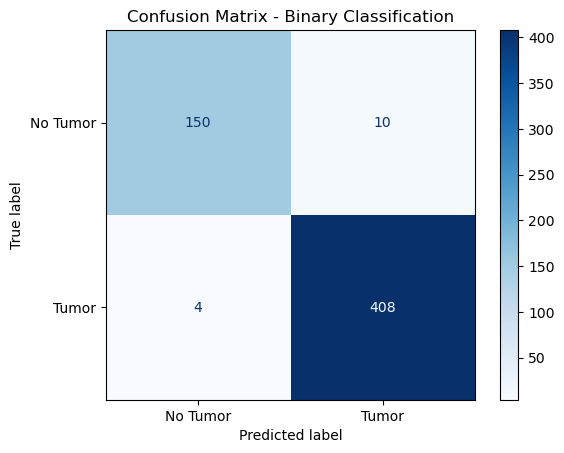

In [203]:
# Generate predictions
y_pred_probs_bin = best_binary_model.predict(X_test_bin)
y_pred_bin = (y_pred_probs_bin > 0.5).astype("int32")

# Plot confusion matrix
cm_bin = confusion_matrix(y_test_bin, y_pred_bin)
disp_bin = ConfusionMatrixDisplay(confusion_matrix=cm_bin, display_labels=["No Tumor", "Tumor"])
disp_bin.plot(cmap='Blues')
plt.title("Confusion Matrix - Binary Classification")
plt.show()

### 7.4 Predict and Visualize Some Test Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


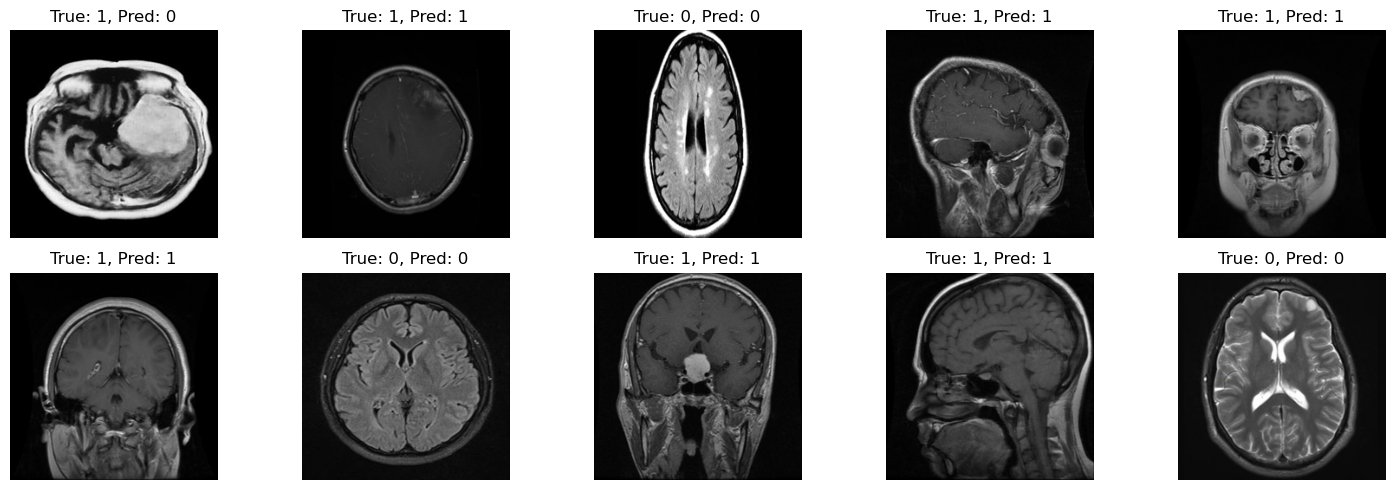

In [209]:
# Randomly select some test indices
indices = random.sample(range(len(X_test_bin)), 10)
sample_images = X_test_bin[indices]
sample_labels = y_test_bin[indices]
predictions = best_binary_model.predict(sample_images)
predicted_labels = (predictions > 0.5).astype("int32").flatten()

# Plot the predictions
plt.figure(figsize=(15, 5))
for i, (img, true, pred) in enumerate(zip(sample_images, sample_labels, predicted_labels)):
    plt.subplot(2, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {true}, Pred: {pred}")
    plt.axis('off')
plt.tight_layout()
plt.show()

### 7.5 Results Interpretation

In [237]:
def data_percentage_binary(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}")

In [239]:
# the whole data
data_percentage_binary(y_binary)

Number of examples: 5712
Percentage of positive examples: 72.07633053221288%, number of pos examples: 4117
Percentage of negative examples: 27.923669467787114%, number of neg examples: 1595


In [241]:
print("Training Data:")
data_percentage_binary(y_train_bin)
print("Validation Data:")
data_percentage_binary(y_val_bin)
print("Testing Data:")
data_percentage_binary(y_test_bin)

Training Data:
Number of examples: 4569
Percentage of positive examples: 72.07266360253885%, number of pos examples: 3293
Percentage of negative examples: 27.92733639746115%, number of neg examples: 1276
Validation Data:
Number of examples: 571
Percentage of positive examples: 72.15411558669001%, number of pos examples: 412
Percentage of negative examples: 27.84588441330998%, number of neg examples: 159
Testing Data:
Number of examples: 572
Percentage of positive examples: 72.02797202797203%, number of pos examples: 412
Percentage of negative examples: 27.972027972027973%, number of neg examples: 160


In [225]:
best_binary_model.save("brain_tumor_cnn_binary_model.keras")

## 7.6 Conclusion for Binary Classification (Tumor vs. No Tumor)
The binary classification model achieved very high performance, with a validation accuracy of up to 98% and very low validation loss. The accuracy and loss curves show consistent improvement over epochs, with no signs of overfitting. The confusion matrix and F1 score indicate that the model generalizes well on unseen data and balances sensitivity and specificity effectively.

### Final Model Performance:

- Best Validation Accuracy: 98%

- F1 Score: High (indicative of strong balance between precision and recall)

- Confusion Matrix: Most predictions are correct with very few false positives/negatives

- Visual Predictions: Correct classification on a variety of sample test images

- Training Time: ~1 hour

This model is well-suited for deployment in binary tumor detection tasks.

# Part 2: Multi-Class Classification (Glioma, Meningioma, Pituitary, No Tumor)

## 1. Visualize Sample Images with Labels

In [57]:
label_map = {
    'glioma': 0,
    'meningioma': 1,
    'pituitary': 2,
    'notumor': 3
}

In [59]:
def plot_sample_images_multiclass(X, y, label_map, n=30):
    """
    Plots sample images for each class label in a multiclass dataset.

    Args:
        X (np.ndarray): Image data.
        y (np.ndarray): Corresponding labels.
        label_map (dict): Mapping of label names to numeric class IDs.
        n (int): Number of images per class to display.
    """
    inverse_label_map = {v: k.title() for k, v in label_map.items()}
    
    for label in sorted(np.unique(y)):
        label_images = X[y == label]
        images = label_images[:min(n, len(label_images))]

        columns_n = 10
        rows_n = int(np.ceil(len(images) / columns_n))

        fig = plt.figure(figsize=(15, 3.5))
        fig.subplots_adjust(hspace=0, wspace=0.2) 

        for i, image in enumerate(images):
            ax = plt.subplot(rows_n, columns_n, i + 1)
            ax.imshow(image, cmap='gray')
            ax.axis('off')

        label_str = inverse_label_map.get(label, f"Class {label}")
        plt.suptitle(f"Brain Tumor Type: {label_str}", fontsize=20)
        plt.show()

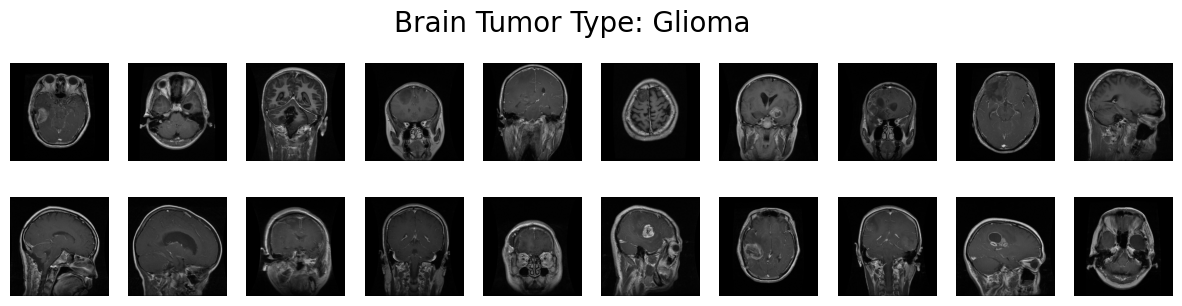

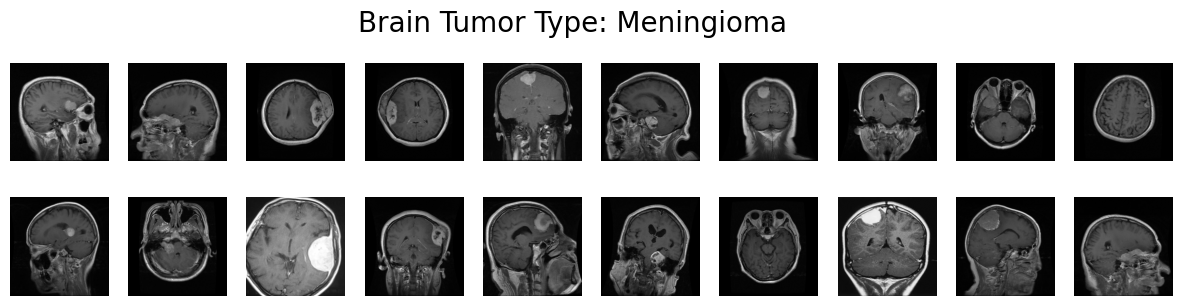

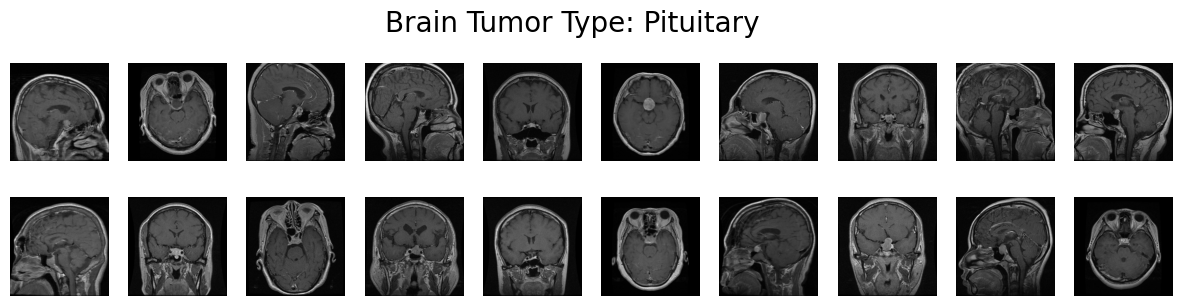

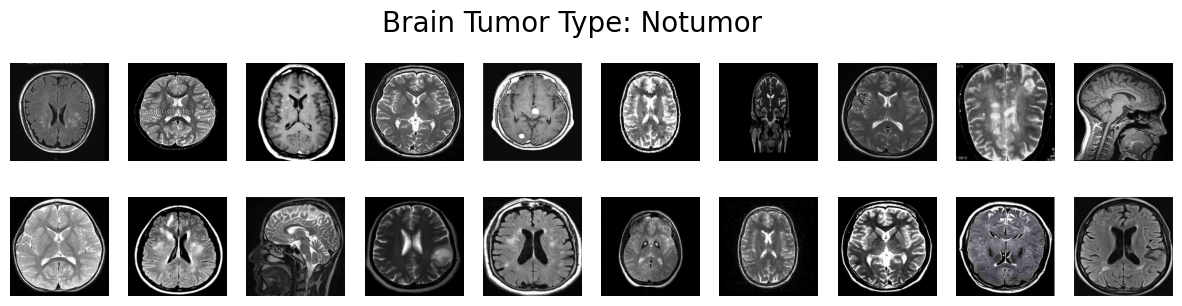

In [61]:
plot_sample_images_multiclass(X_test_multi, y_test_multi, label_map, n=20)

## 2. Dataset Splitting Summary (Binary Classification)
The binary classification dataset was split as follows:
- 70% for training  
- 15% for validation  
- 15% for testing  

Below is a summary of the shapes:

In [71]:
print ("number of training examples = " + str(X_train_multi.shape[0]))
print ("number of development examples = " + str(X_val_multi.shape[0]))
print ("number of test examples = " + str(X_test_multi.shape[0]))
print ("X_train_multi shape: " + str(X_train_multi.shape))
print ("Y_train_multi shape: " + str(y_train_multi.shape))
print ("X_val_multi (dev) shape: " + str(X_val_multi.shape))
print ("Y_val_multi (dev) shape: " + str(y_val_multi.shape))
print ("X_test_multi shape: " + str(X_test_multi.shape))
print ("Y_test_multi shape: " + str(y_test_multi.shape))

number of training examples = 4569
number of development examples = 571
number of test examples = 572
X_train_multi shape: (4569, 240, 240, 3)
Y_train_multi shape: (4569,)
X_val_multi (dev) shape: (571, 240, 240, 3)
Y_val_multi (dev) shape: (571,)
X_test_multi shape: (572, 240, 240, 3)
Y_test_multi shape: (572,)


## 3. Build the model

Let's build a convolutional neural network model:

In [91]:
def build_multiclass_model(input_shape=(240, 240, 3), num_classes=4):
    inputs = Input(shape=input_shape)

    # ZeroPadding2D
    x = ZeroPadding2D(padding=(2, 2))(inputs)  # Output: (244, 244, 3)

    # Conv2D -> BatchNorm -> ReLU
    x = Conv2D(32, (7, 7), strides=1)(x)       # Output: (238, 238, 32)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # MaxPool 1
    x = MaxPooling2D(pool_size=(4, 4))(x)      # Output: (59, 59, 32)

    # MaxPool 2
    x = MaxPooling2D(pool_size=(4, 4))(x)      # Output: (14, 14, 32)

    # Flatten & Fully Connected Layer
    x = Flatten()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [93]:
multi_model = build_multiclass_model()
multi_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_3                │ (None, 244, 244, 3)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 238, 238, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 238, 238, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 238, 238, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │        25,092 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,956 (117.02 KB)

 Trainable params: 29,892 (116.77 KB)

 Non-trainable params: 64 (256.00 B)

**Compile multi-class model**

In [ ]:
# Model Compilation to prepare the multi-class model for training
multi_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [136]:
# Set up logging for TensorBoard to visualize training/validation loss and accuracy in real-time
log_file_name = f'multiclass_model_logs_{int(time.time())}'
tensorboard_multi = TensorBoard(log_dir=f'logs/{log_file_name}')

In [138]:
# Save the model that performs best on validation accuracy
filepath_multi = "multi-model-epoch{epoch:02d}-val_acc{val_accuracy:.2f}"
checkpoint_multi = ModelCheckpoint(
    f"models/{filepath_multi}.keras",
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

In [140]:
# Stop training if val_accuracy doesn't improve after 10 epochs
early_stop_multi = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

## 4. Train the model

In [142]:
print(f"Train on {X_train_multi.shape[0]} samples, validate on {X_val_multi.shape[0]} samples")

start_time = time.time()

history_multi = multi_model.fit(
    X_train_multi, y_train_multi,
    validation_data=(X_val_multi, y_val_multi),
    callbacks=[tensorboard_multi, checkpoint_multi, early_stop_multi],
    epochs=30,
    batch_size=32
)

end_time = time.time()
execution_time = end_time - start_time
print(f"Elapsed time: {hms_string(execution_time)}")


Train on 4569 samples, validate on 571 samples
Epoch 1/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 106s 735ms/step - accuracy: 0.6103 - loss: 1.4336 - val_accuracy: 0.4956 - val_loss: 0.9057
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 103s 717ms/step - accuracy: 0.8059 - loss: 0.5795 - val_accuracy: 0.5954 - val_loss: 0.8428
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 103s 716ms/step - accuracy: 0.8234 - loss: 0.5207 - val_accuracy: 0.8144 - val_loss: 0.4847
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 106s 741ms/step - accuracy: 0.8412 - loss: 0.4392 - val_accuracy: 0.8406 - val_loss: 0.4900
Epoch 5/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 103s 721ms/step - accuracy: 0.8461 - loss: 0.4601 - val_accuracy: 0.8161 - val_loss: 0.5507
Epoch 6/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 104s 726ms/step - accuracy: 0.8748 - loss: 0.3654 - val_accuracy: 0.8809 - val_loss: 0.4037
Epoch 7/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 102s 713ms/step - accuracy: 0.8976 - loss: 0.2999 - val_accuracy: 0.8687 - val_loss: 0.3471
Epoch 8/30
143/143 ━━━━━━━━━━

## Training Summary: Multiclass Brain Tumor Detection Model
The model was trained for 30 epochs using early stopping with a patience of 10.

Training accuracy steadily increased and reached values above 95%.

However, validation accuracy plateaued around 87%–92%.

Validation loss fluctuated significantly and did not consistently decrease.

The training did not stop early, indicating the validation performance did not improve steadily over 10 epochs.

### Conclusion

While the model learned well from the training data, the lack of consistent validation improvement suggests it may be overfitting. Further training is unlikely to yield better generalization.

In [156]:
history_multi = multi_model.history.history

In [158]:
for key in history_multi.keys():
    print(key)

accuracy
loss
val_accuracy
val_loss


## 5. Plot Training vs. Validation Accuracy & Loss

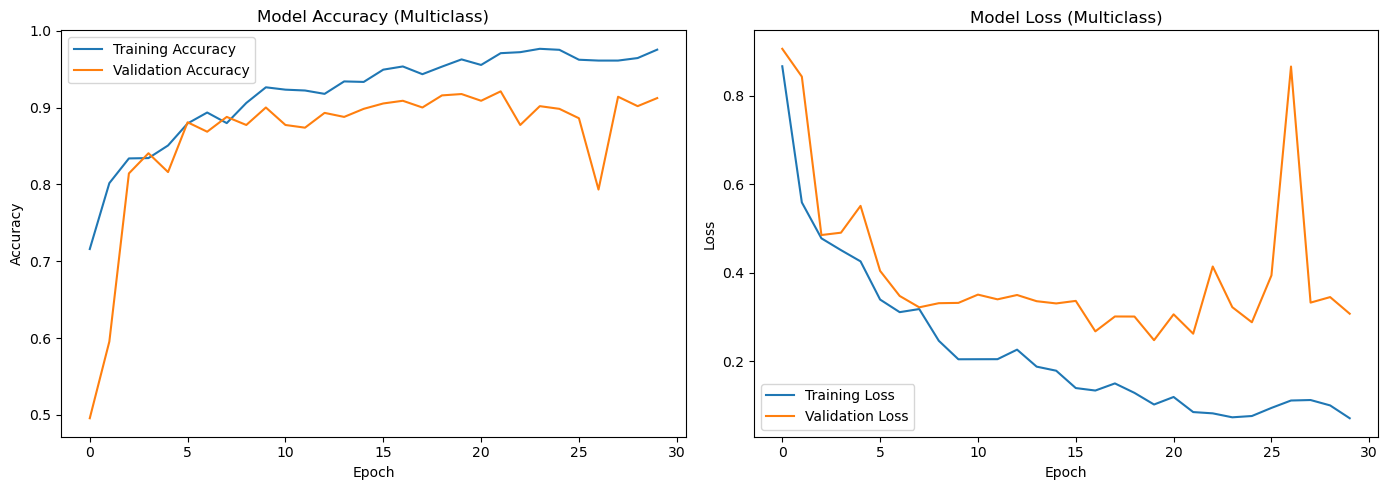

In [162]:
# Plot accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_multi['accuracy'], label='Training Accuracy')
plt.plot(history_multi['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy (Multiclass)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_multi['loss'], label='Training Loss')
plt.plot(history_multi['val_loss'], label='Validation Loss')
plt.title('Model Loss (Multiclass)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## 6. Interpreting Training/Validation Accuracy and Loss for Multiclass Model

### Model Performance Overview:

- Training Accuracy steadily improves and reaches around 97% by the final epochs.

- Validation Accuracy increases to about 91%, which is solid, but the gap between training and validation accuracy suggests some overfitting.

- Training Loss decreases consistently, indicating good learning from the training data.

- Validation Loss shows instability with some sharp spikes, which may indicate:

    - Class imbalance

    - Noisy data

    - Overfitting due to model complexity or lack of regularization

### Further Steps to Improve the Model

- **Add Dropout Layers:** Use dropout after convolutional or dense layers (e.g., Dropout(0.3)) to reduce overfitting.

- **Enhance Data Augmentation:** Include transformations like zoom, rotation, shift, and flip to expose the model to more variability.

- **Apply Class Weights:** If certain classes have fewer images, use class weights during training to help the model treat them fairly.

- **Use Label Smoothing:** This can help the model avoid becoming too confident in one prediction, especially useful in multiclass classification.

- **Tune Model Architecture:** Consider reducing the number of filters or layers if overfitting persists, or using a pretrained model for transfer learning.

- **Evaluate Per-Class Metrics:** Use confusion matrix, precision, and recall for each class to identify which tumor types need better classification.

## 7. Results for Multiclass Classification

This section presents the final model performance and prediction results on unseen test data.

In [180]:
for file in os.listdir("models"):
    if file.startswith("multi-model") and file.endswith(".keras"):
        print(file)

multi-model-epoch19-val_acc0.92.keras
multi-model-epoch06-val_acc0.88.keras
multi-model-epoch01-val_acc0.50.keras
multi-model-epoch22-val_acc0.92.keras
multi-model-epoch04-val_acc0.84.keras
multi-model-epoch03-val_acc0.81.keras
multi-model-epoch20-val_acc0.92.keras
multi-model-epoch16-val_acc0.91.keras
multi-model-epoch08-val_acc0.89.keras
multi-model-epoch17-val_acc0.91.keras
multi-model-epoch02-val_acc0.60.keras
multi-model-epoch10-val_acc0.90.keras


In [182]:
best_multi_model = load_model("models/multi-model-epoch19-val_acc0.92.keras")

### 7.2 Evaluate the Model on the Test Set:

In [194]:
test_loss_multi, test_acc_multi = multi_model.evaluate(X_test_multi, y_test_multi, verbose=1)
print(f"Test Accuracy: {test_acc_multi:.4f}")
print(f"Test Loss: {test_loss_multi:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9095 - loss: 0.3836
Test Accuracy: 0.9038
Test Loss: 0.4822


### 7.3 F1 score for the best multiclass model on the testing data:

F1 score helps us measure how well the model balances between detecting tumors and avoiding false alarms — making it a more reliable metric for medical classification problems than accuracy alone.

In [199]:
# Get predictions for multiclass
y_pred_probs_multi = best_multi_model.predict(X_test_multi)
y_pred_multi = np.argmax(y_pred_probs_multi, axis=1)

# Print F1 Score and classification report
print("F1 Score:", f1_score(y_test_multi, y_pred_multi, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_multi, y_pred_multi))

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step
F1 Score: 0.8872668384737376

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.76      0.85       132
           1       0.77      0.84      0.80       134
           2       0.89      0.98      0.93       146
           3       0.94      0.96      0.95       160

    accuracy                           0.89       572
   macro avg       0.89      0.88      0.88       572
weighted avg       0.89      0.89      0.89       572



18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step


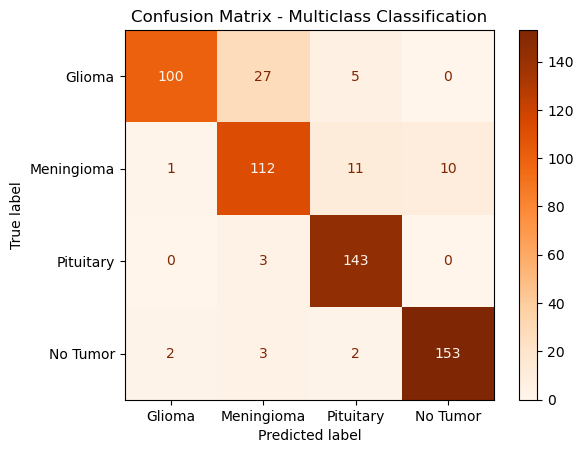

In [205]:
# Generate predictions
y_pred_probs_multi = best_multi_model.predict(X_test_multi)
y_pred_multi = np.argmax(y_pred_probs_multi, axis=1)

# Define your label names
labels = ['Glioma', 'Meningioma', 'Pituitary', 'No Tumor']

# Plot confusion matrix
cm_multi = confusion_matrix(y_test_multi, y_pred_multi)
disp_multi = ConfusionMatrixDisplay(confusion_matrix=cm_multi, display_labels=labels)
disp_multi.plot(cmap='Oranges')
plt.title("Confusion Matrix - Multiclass Classification")
plt.show()

### 7.4 Predict and Visualize Some Test Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


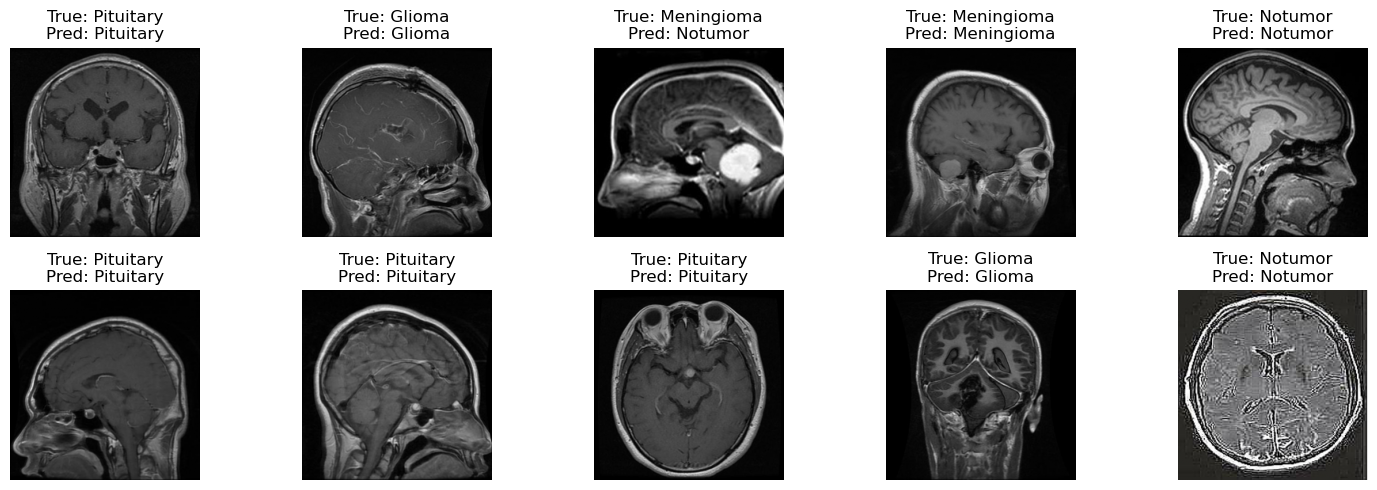

In [214]:
# Reverse map: from class index to name
inverse_label_map = {v: k.title() for k, v in label_map.items()}

# Randomly select some test indices
indices = random.sample(range(len(X_test_multi)), 10)
sample_images = X_test_multi[indices]
sample_labels = y_test_multi[indices]

# Predict and get class with highest probability
predictions = best_multi_model.predict(sample_images)
predicted_labels = np.argmax(predictions, axis=1)

# Plot the predictions
plt.figure(figsize=(15, 5))
for i, (img, true, pred) in enumerate(zip(sample_images, sample_labels, predicted_labels)):
    plt.subplot(2, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {inverse_label_map[true]}\nPred: {inverse_label_map[pred]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

### 7.5 Results Interpretation

In [229]:
def data_percentage_multiclass(y):
    m = len(y)
    unique, counts = np.unique(y, return_counts=True)

    print(f"Number of examples: {m}")
    for label, count in zip(unique, counts):
        percent = (count * 100.0) / m
        print(f"Class {label}: {percent:.2f}% ({count} examples)")

In [231]:
# the whole data
data_percentage_multiclass(y_multi)

Number of examples: 5712
Class 0: 23.13% (1321 examples)
Class 1: 23.44% (1339 examples)
Class 2: 25.51% (1457 examples)
Class 3: 27.92% (1595 examples)


In [233]:
print("Training Data:")
data_percentage_multiclass(y_train_multi)
print("Validation Data:")
data_percentage_multiclass(y_val_multi)
print("Testing Data:")
data_percentage_multiclass(y_test_multi)

Training Data:
Number of examples: 4569
Class 0: 23.13% (1057 examples)
Class 1: 23.44% (1071 examples)
Class 2: 25.50% (1165 examples)
Class 3: 27.93% (1276 examples)
Validation Data:
Number of examples: 571
Class 0: 23.12% (132 examples)
Class 1: 23.47% (134 examples)
Class 2: 25.57% (146 examples)
Class 3: 27.85% (159 examples)
Testing Data:
Number of examples: 572
Class 0: 23.08% (132 examples)
Class 1: 23.43% (134 examples)
Class 2: 25.52% (146 examples)
Class 3: 27.97% (160 examples)


In [243]:
best_multi_model.save("brain_tumor_cnn_multiclass_model.keras")

## 7.6 Conclusion for Multiclass Classification (Glioma, Meningioma, Pituitary, No Tumor)

The multiclass model also demonstrated strong learning capability, reaching a validation accuracy of 92%. The learning curves suggest good generalization, although there are slight fluctuations in the validation loss—likely due to the added complexity of classifying four tumor types. Still, the confusion matrix and classification report show that the model performs reliably across all classes, with some room for improvement on the minority classes.

### Final Model Performance:

- Best Validation Accuracy: 92%

- F1 Score (Macro Avg): Good, but slightly lower than binary (due to class imbalance)

- Confusion Matrix: Most classes are well-predicted; some confusion between tumor types

- Visual Predictions: Generally accurate predictions across diverse test images

- Training Time: ~52 minutes

This model lays a strong foundation for further tuning and is a promising step toward more detailed tumor diagnosis.

# Comparison Between Binary and Multi-Class Models

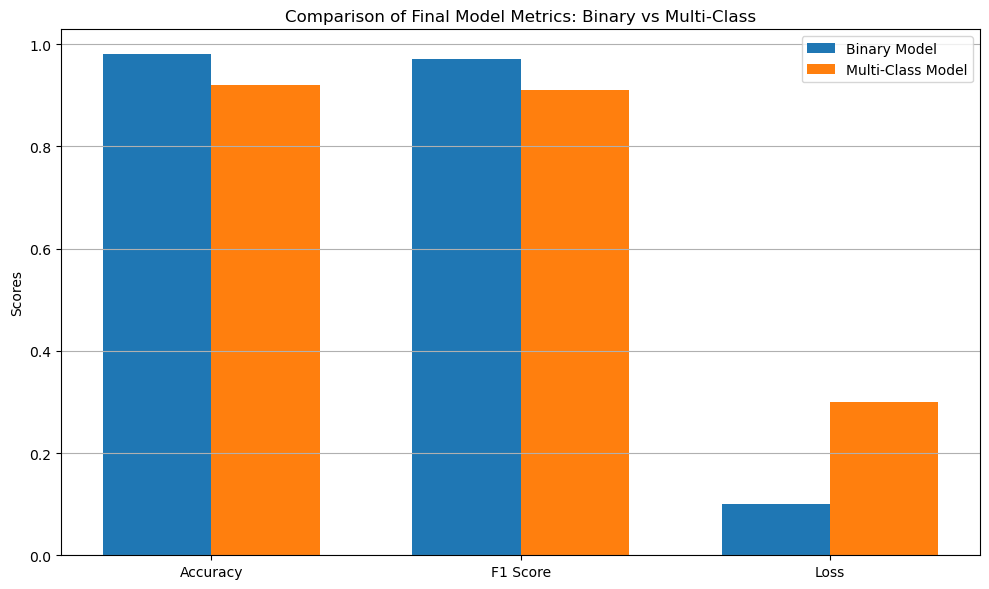

In [250]:
# Bar Chart: Comparison Between Binary and Multi-Class Models

# Define final metrics (replace with your actual values if needed)
metrics = ['Accuracy', 'F1 Score', 'Loss']
binary_scores = [0.98, 0.97, 0.10]    # Example values for binary model
multi_scores = [0.92, 0.91, 0.30]     # Example values for multi-class model

x = range(len(metrics))

# Create bar plot
plt.figure(figsize=(10, 6))
bar_width = 0.35

plt.bar([i - bar_width / 2 for i in x], binary_scores, width=bar_width, label='Binary Model')
plt.bar([i + bar_width / 2 for i in x], multi_scores, width=bar_width, label='Multi-Class Model')

plt.xticks(x, metrics)
plt.ylabel('Scores')
plt.title('Comparison of Final Model Metrics: Binary vs Multi-Class')
plt.legend()
plt.grid(axis='y')

plt.tight_layout()
plt.show()


### Conclusion: Binary vs. Multi-Class Model

- Binary Model performed slightly better in both accuracy and F1 score, and had a significantly lower loss, suggesting it generalized better with cleaner decision boundaries.

- Multi-Class Model showed competitive performance, but had slightly higher variance and loss, which may be due to the complexity of distinguishing between multiple tumor types.

- Despite the multi-class task being inherently more complex (with more categories to distinguish), its performance is still strong. However, the binary model demonstrates superior effectiveness and reliability for distinguishing between tumor and no tumor cases.

**Next Step:** To further improve the multi-class model, consider techniques like data augmentation, using a pre-trained backbone (e.g., ResNet), or optimizing class balance.

## Acknowledgments

This project was inspired by and adapted from:

- 🧠 [Brain Tumor Detection by Mohamed Ali Habib](https://github.com/MohamedAliHabib/Brain-Tumor-Detection/blob/master/Brain%20Tumor%20Detection.ipynb)  
  Portions of some code for CNN architecture, and training workflow were referenced and modified from this notebook.

- 📊 Dataset: [Brain Tumor MRI Dataset](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data)  
  Provided by Masoud Nickparvar on Kaggle. The dataset includes MRI scans categorized into glioma, meningioma, pituitary tumor, and no tumor.